# Práctica 1 — Problema de Clique Máximo

**Autor:** Jordi Blasco Lozano

### Índice
1. Introducción y carga de conjuntos de datos
2. Parte 0 — Fuerza bruta para clique máximo
3. Parte 1 — Formulación de Motzkin-Straus
4. Parte 2 — Dinámicas replicadoras
5. Ejercicios y resultados
6. Entregables (discusión final)

## Sesión práctica: Problema de Clique Máximo

### Introducción

En este notebook resuelvo el problema de **Maximum Clique (MC)** siguiendo exactamente la estructura de la práctica:

0. **Fuerza bruta (Brute Force)**
1. **Formulación de Motzkin-Straus**
2. **Dinámicas replicadoras (RD)**

El objetivo es comparar un baseline exacto (pero caro) frente a una relajación continua eficiente, aplicándolo a **IMDB-BINARY** y **COLLAB**.


### Conjuntos de datos


In [18]:
import torch
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import time
from itertools import combinations

from torch_geometric.datasets import TUDataset
from torch_geometric.utils import to_networkx

try:
    import pandas as pd
    from IPython.display import display
except Exception:
    pd = None
    display = print

# Carga de IMDB-BINARY
try:
    imdb_dataset = TUDataset(root='./data', name='IMDB-BINARY')
    print(f"IMDB-BINARY: {len(imdb_dataset)} grafos")

    # Carga de COLLAB
    collab_dataset = TUDataset(root='./data', name='COLLAB')
    print(f"COLLAB: {len(collab_dataset)} grafos")

    # Estadísticas de ejemplo
    sample_graph = imdb_dataset[0]
    print("\nEstadísticas del grafo de ejemplo:")
    print(f"  Nodos: {sample_graph.num_nodes}")
    print(f"  Aristas: {sample_graph.num_edges}")

    if pd is None:
        print("\nAviso: pandas no está disponible; las tablas se mostrarán como texto.")
except Exception as exc:
    imdb_dataset = None
    collab_dataset = None
    print(f"Error al cargar datasets: {exc}")
    print("Ejecuta esta celda en un entorno con dependencias PyG instaladas.")


IMDB-BINARY: 1000 grafos
COLLAB: 5000 grafos

Estadísticas del grafo de ejemplo:
  Nodos: 20
  Aristas: 146


---

## Parte 0: Fuerza bruta para clique máximo

### Tarea 0.1: Implementar `is_clique()`


In [19]:
def is_clique(nodes, A):
    """
    Comprueba si un conjunto de nodos forma un clique.

    Args:
        nodes: lista de índices de nodos
        A: matriz de adyacencia (n, n)

    Returns:
        bool
    """
    if len(nodes) < 2:
        return True

    for i, j in combinations(nodes, 2):
        if A[i, j] <= 0:
            return False

    return True


### Tarea 0.2: Implementar `brute_force_max_clique()`


In [20]:
def brute_force_max_clique(A):
    """
    Encuentra el clique máximo por enumeración exhaustiva.

    Args:
        A: matriz de adyacencia (n, n)

    Returns:
        list: nodos del clique máximo
    """
    n = A.shape[0]

    if n == 0:
        return []

    for k in range(n, 0, -1):
        for subset in combinations(range(n), k):
            if is_clique(subset, A):
                return list(subset)

    return []


### Tarea 0.3: Prueba en grafos pequeños y medida de tiempo


In [21]:
def test_brute_force():
    """Prueba rápida en un grafo pequeño."""
    A = np.array([
        [0, 1, 1, 0],
        [1, 0, 1, 0],
        [1, 1, 0, 1],
        [0, 0, 1, 0]
    ], dtype=float)

    start = time.time()
    clique = brute_force_max_clique(A)
    elapsed = time.time() - start

    print(f"Clique máximo: {clique}")
    print(f"Tamaño del clique: {len(clique)}")
    print(f"Tiempo: {elapsed:.6f} segundos")
    print(f"¿Clique válido?: {is_clique(clique, A)}")


test_brute_force()


Clique máximo: [0, 1, 2]
Tamaño del clique: 3
Tiempo: 0.000015 segundos
¿Clique válido?: True


### Tarea 0.4: Aplicar brute force a IMDB y COLLAB (solo grafos pequeños)


In [22]:
def evaluate_brute_force_on_dataset(dataset, max_graphs=10, max_nodes=25):
    """
    Evalúa brute force en un dataset (solo grafos pequeños).

    Returns:
        DataFrame (si pandas está disponible) o lista de diccionarios.
    """
    resultados = []

    if dataset is None:
        print("Dataset no cargado.")
        return pd.DataFrame() if pd is not None else resultados

    for i in range(min(max_graphs, len(dataset))):
        data = dataset[i]

        if data.num_nodes > max_nodes:
            print(f"Grafo {i}: se omite (demasiado grande: {data.num_nodes} nodos)")
            continue

        G = to_networkx(data, to_undirected=True)
        A = nx.to_numpy_array(G, dtype=float)

        start = time.time()
        clique = brute_force_max_clique(A)
        elapsed = time.time() - start

        fila = {
            'graph_idx': i,
            'num_nodes': int(data.num_nodes),
            'clique_size': int(len(clique)),
            'time_s': float(elapsed)
        }
        resultados.append(fila)
        print(f"Grafo {i}: clique={len(clique)}, tiempo={elapsed:.6f}s")

    if pd is not None:
        return pd.DataFrame(resultados)
    return resultados


def summarize_bruteforce_results(resultados, nombre):
    if pd is not None and isinstance(resultados, pd.DataFrame):
        if resultados.empty:
            print(f"{nombre}: sin grafos evaluados.")
            return

        display(resultados)
        resumen = pd.DataFrame([{
            'dataset': nombre,
            'grafos_evaluados': int(len(resultados)),
            'clique_medio': float(resultados['clique_size'].mean()),
            'clique_std': float(resultados['clique_size'].std(ddof=0)),
            'tiempo_medio_s': float(resultados['time_s'].mean())
        }])
        display(resumen)
    else:
        if not resultados:
            print(f"{nombre}: sin grafos evaluados.")
            return
        sizes = np.array([r['clique_size'] for r in resultados], dtype=float)
        times = np.array([r['time_s'] for r in resultados], dtype=float)
        print(f"\n{nombre}")
        print(f"  Grafos evaluados: {len(resultados)}")
        print(f"  Clique medio: {sizes.mean():.2f} +- {sizes.std():.2f}")
        print(f"  Tiempo medio: {times.mean():.6f} s")


In [23]:
# Primera ejecución sobre subconjuntos manejables
if imdb_dataset is not None:
    brute_imdb_df = evaluate_brute_force_on_dataset(imdb_dataset, max_graphs=20, max_nodes=25)
    summarize_bruteforce_results(brute_imdb_df, "IMDB-BINARY (Brute Force)")
else:
    brute_imdb_df = pd.DataFrame() if pd is not None else []

if collab_dataset is not None:
    brute_collab_df = evaluate_brute_force_on_dataset(collab_dataset, max_graphs=10, max_nodes=25)
    summarize_bruteforce_results(brute_collab_df, "COLLAB (Brute Force)")
else:
    brute_collab_df = pd.DataFrame() if pd is not None else []


Grafo 0: clique=9, tiempo=0.319982s
Grafo 1: se omite (demasiado grande: 32 nodos)
Grafo 2: clique=10, tiempo=0.542193s
Grafo 3: se omite (demasiado grande: 35 nodos)
Grafo 4: clique=9, tiempo=0.002920s
Grafo 5: se omite (demasiado grande: 63 nodos)
Grafo 6: clique=12, tiempo=0.000011s
Grafo 7: clique=9, tiempo=0.003660s
Grafo 8: clique=18, tiempo=0.000020s
Grafo 9: clique=12, tiempo=0.000010s
Grafo 10: clique=8, tiempo=0.000193s
Grafo 11: clique=20, tiempo=0.000024s
Grafo 12: clique=10, tiempo=0.000110s
Grafo 13: clique=12, tiempo=0.070605s
Grafo 14: se omite (demasiado grande: 72 nodos)
Grafo 15: clique=20, tiempo=0.000024s
Grafo 16: clique=13, tiempo=0.011062s
Grafo 17: clique=8, tiempo=0.000512s
Grafo 18: clique=6, tiempo=0.160479s
Grafo 19: se omite (demasiado grande: 46 nodos)


,graph_idx,num_nodes,clique_size,time_s
0,0,20,9,0.319982
1,2,21,10,0.542193
2,4,14,9,0.002920
3,6,12,12,0.000011
4,7,15,9,0.003660
5,8,18,18,0.000020
6,9,12,12,0.000010
7,10,12,8,0.000193
8,11,20,20,0.000024
9,12,13,10,0.000110


,dataset,grafos_evaluados,clique_medio,clique_std,tiempo_medio_s
0,IMDB-BINARY (Brute Force),15,11.733333,4.218478,0.07412


Grafo 0: se omite (demasiado grande: 45 nodos)
Grafo 1: se omite (demasiado grande: 52 nodos)
Grafo 2: se omite (demasiado grande: 52 nodos)
Grafo 3: se omite (demasiado grande: 32 nodos)
Grafo 4: se omite (demasiado grande: 48 nodos)
Grafo 5: se omite (demasiado grande: 39 nodos)
Grafo 6: se omite (demasiado grande: 35 nodos)
Grafo 7: se omite (demasiado grande: 81 nodos)
Grafo 8: se omite (demasiado grande: 65 nodos)
Grafo 9: se omite (demasiado grande: 49 nodos)
COLLAB (Brute Force): sin grafos evaluados.


---

## Parte 1: Formulación de Motzkin-Straus

### Tarea 1.1: Implementar funciones objetivo


In [24]:
def motzkin_straus_objective(x, A):
    """Calcula f(x) = x^T A x."""
    return float(x.T @ A @ x)


def regularized_objective(x, A):
    """Calcula f_hat(x) = x^T (A + 0.5 I) x."""
    n = A.shape[0]
    A_reg = A + 0.5 * np.eye(n)
    return float(x.T @ A_reg @ x)


### Tarea 1.2: Verificar Motzkin-Straus en ejemplos


In [25]:
def simplex_point_from_clique(clique, n):
    x = np.zeros(n, dtype=float)
    if len(clique) > 0:
        x[clique] = 1.0 / len(clique)
    return x


def verify_motzkin_straus():
    """Verifica Motzkin-Straus en grafos de control."""
    A1 = np.array([
        [0, 1, 1],
        [1, 0, 1],
        [1, 1, 0]
    ], dtype=float)

    A2 = np.array([
        [0, 1, 1, 1],
        [1, 0, 1, 0],
        [1, 1, 0, 1],
        [1, 0, 1, 0]
    ], dtype=float)

    grafos = [("Triángulo K3", A1), ("Cuadrado + diagonal", A2)]

    filas = []
    print("Verificación Motzkin-Straus")
    for nombre, A in grafos:
        clique = brute_force_max_clique(A)
        k = len(clique)
        x_star = simplex_point_from_clique(clique, A.shape[0])
        f_x = motzkin_straus_objective(x_star, A)
        rhs = 1.0 - 1.0 / k

        filas.append({
            'grafo': nombre,
            'clique': clique,
            'k': k,
            'f(x*)': f_x,
            '1-1/k': rhs,
            'coincide': bool(np.isclose(f_x, rhs, atol=1e-10))
        })

        print(f"\n{nombre}")
        print(f"  Clique máximo: {clique} (k={k})")
        print(f"  f(x*): {f_x:.6f}")
        print(f"  1 - 1/k: {rhs:.6f}")

    A3 = np.array([
        [0, 0, 1],
        [0, 0, 1],
        [1, 1, 0]
    ], dtype=float)

    x_true = np.array([0.5, 0.0, 0.5], dtype=float)
    x_spurious = np.array([0.25, 0.25, 0.5], dtype=float)

    f_true = motzkin_straus_objective(x_true, A3)
    f_spur = motzkin_straus_objective(x_spurious, A3)
    fhat_true = regularized_objective(x_true, A3)
    fhat_spur = regularized_objective(x_spurious, A3)

    df_cherry = {
        'f_true': f_true,
        'f_espuria': f_spur,
        'f_hat_true': fhat_true,
        'f_hat_espuria': fhat_spur,
        'regularizacion_prefiere_clique': fhat_true > fhat_spur
    }

    print("\nCherry graph (solución espuria)")
    print(f"  f(x_true): {f_true:.6f}")
    print(f"  f(x_espuria): {f_spur:.6f}")
    print(f"  f_hat(x_true): {fhat_true:.6f}")
    print(f"  f_hat(x_espuria): {fhat_spur:.6f}")

    if pd is not None:
        df_ver = pd.DataFrame(filas)
        df_ch = pd.DataFrame([df_cherry])
        display(df_ver)
        display(df_ch)
        return df_ver, df_ch

    return filas, df_cherry


verify_motzkin_straus()


Verificación Motzkin-Straus

Triángulo K3
  Clique máximo: [0, 1, 2] (k=3)
  f(x*): 0.666667
  1 - 1/k: 0.666667

Cuadrado + diagonal
  Clique máximo: [0, 1, 2] (k=3)
  f(x*): 0.666667
  1 - 1/k: 0.666667

Cherry graph (solución espuria)
  f(x_true): 0.500000
  f(x_espuria): 0.500000
  f_hat(x_true): 0.750000
  f_hat(x_espuria): 0.687500


,grafo,clique,k,f(x*),1-1/k,coincide
0,Triángulo K3,"[0, 1, 2]",3,0.666667,0.666667,True
1,Cuadrado + diagonal,"[0, 1, 2]",3,0.666667,0.666667,True


,f_true,f_espuria,f_hat_true,f_hat_espuria,regularizacion_prefiere_clique
0,0.5,0.5,0.75,0.6875,True


(                 grafo     clique  k     f(x*)     1-1/k  coincide
 0         Triángulo K3  [0, 1, 2]  3  0.666667  0.666667      True
 1  Cuadrado + diagonal  [0, 1, 2]  3  0.666667  0.666667      True,
    f_true  f_espuria  f_hat_true  f_hat_espuria  \
 0     0.5        0.5        0.75         0.6875   
 
    regularizacion_prefiere_clique  
 0                            True  )

### Motzkin-Straus 

El teorema de Motzkin-Straus nos dice qué optimizar; Replicator Dynamics nos da un método práctico para cómo encontrar una solución sobre el simplex.


---

## Parte 2: Dinámicas replicadoras

### Tarea 2.1: Implementar RD (formulación de Pelillo)


In [26]:
def replicator_dynamics(A, max_iter=1000, tol=1e-12, use_regularization=True):
    """
    Ejecuta Replicator Dynamics para aproximar clique máximo.

    Actualización (Pelillo):
    x_new = x * (A @ x)
    x_new = x_new / x_new.sum()
    """
    n = A.shape[0]
    if n == 0:
        return np.array([], dtype=float), {'objectives': [], 'iterations': 0}

    if use_regularization:
        A_reg = A + 0.5 * np.eye(n)
    else:
        A_reg = A.copy()

    x = np.ones(n, dtype=float) / n
    history = {'objectives': [float(x @ A_reg @ x)], 'iterations': 0}

    for t in range(max_iter):
        x_old = x.copy()
        x_new = x * (A_reg @ x)
        z = x_new.sum()

        if z <= 0:
            break

        x = x_new / z
        history['objectives'].append(float(x @ A_reg @ x))
        history['iterations'] = t + 1

        if np.linalg.norm(x - x_old, ord=1) < tol:
            break

    return x, history


### Tarea 2.2: Implementar el decodificador de clique


In [27]:
def decode_clique(x, A, threshold=1e-6):
    """
    Decodifica un clique desde la solución de RD.

    Estrategia:
    1) ordenar nodos por x_i descendente
    2) añadir greedily si mantiene propiedad de clique
    """
    if x.size == 0:
        return []

    indices = np.argsort(-x)
    clique = []

    for i in indices:
        if x[i] < threshold and len(clique) > 0:
            break

        can_extend = True
        for j in clique:
            if A[j, i] <= 0:
                can_extend = False
                break

        if can_extend:
            clique.append(int(i))

    if not clique:
        clique = [int(indices[0])]

    return clique


### Tarea 2.3: Visualizar convergencia de RD


In [28]:
def visualize_rd(A, graph_name="Grafo de prueba"):
    """Ejecuta RD y visualiza convergencia."""
    x_final, history = replicator_dynamics(A)
    n = A.shape[0]

    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    # 1) Objetivo por iteración
    axes[0].plot(history['objectives'], linewidth=2)
    axes[0].set_title('Objetivo f(x(t))')
    axes[0].set_xlabel('Iteración')
    axes[0].set_ylabel('Valor')
    axes[0].grid(alpha=0.3)

    # 2) Distribución final de x
    axes[1].bar(np.arange(n), x_final)
    axes[1].set_title('Valores finales de x')
    axes[1].set_xlabel('Nodo')
    axes[1].set_ylabel('x_i')

    # 3) Grafo coloreado por score de nodo
    G = nx.from_numpy_array(A)
    pos = nx.spring_layout(G, seed=42)
    nodes = nx.draw_networkx_nodes(
        G, pos, node_color=x_final, cmap='viridis', node_size=300, ax=axes[2]
    )
    nx.draw_networkx_edges(G, pos, ax=axes[2], alpha=0.5)
    nx.draw_networkx_labels(G, pos, ax=axes[2], font_size=9)
    axes[2].set_title('Grafo coloreado por x_i')
    axes[2].axis('off')
    plt.colorbar(nodes, ax=axes[2], fraction=0.046, pad=0.04, label='x_i')

    clique = decode_clique(x_final, A)
    plt.suptitle(f"Replicator Dynamics: {graph_name} | clique decodificado={clique}")
    plt.tight_layout()
    plt.show()

    return x_final


### Tarea 2.4: Aplicar RD a IMDB y COLLAB


In [29]:
def evaluate_rd_on_dataset(dataset, dataset_name, num_graphs=50):
    """Evalúa Replicator Dynamics en un dataset."""
    resultados = []

    if dataset is None:
        print(f"{dataset_name}: dataset no cargado.")
        return pd.DataFrame() if pd is not None else resultados

    total = min(num_graphs, len(dataset))
    for i in range(total):
        data = dataset[i]
        G = to_networkx(data, to_undirected=True)
        A = nx.to_numpy_array(G, dtype=float)

        start_time = time.time()
        x_final, history = replicator_dynamics(A, max_iter=1000)
        clique = decode_clique(x_final, A)
        elapsed = time.time() - start_time

        resultados.append({
            'graph_idx': i,
            'num_nodes': int(data.num_nodes),
            'clique_size': int(len(clique)),
            'valid': bool(is_clique(clique, A)),
            'time_s': float(elapsed),
            'iterations': int(history['iterations'])
        })

        if (i + 1) % 10 == 0:
            print(f"Procesados {i + 1}/{total} grafos")

    if pd is not None:
        df = pd.DataFrame(resultados)
        if not df.empty:
            resumen = pd.DataFrame([{
                'dataset': dataset_name,
                'grafos': int(len(df)),
                'clique_medio': float(df['clique_size'].mean()),
                'clique_std': float(df['clique_size'].std(ddof=0)),
                'tiempo_medio_s': float(df['time_s'].mean()),
                'ratio_clique_valido': float(df['valid'].mean())
            }])
            display(resumen)
        return df

    return resultados


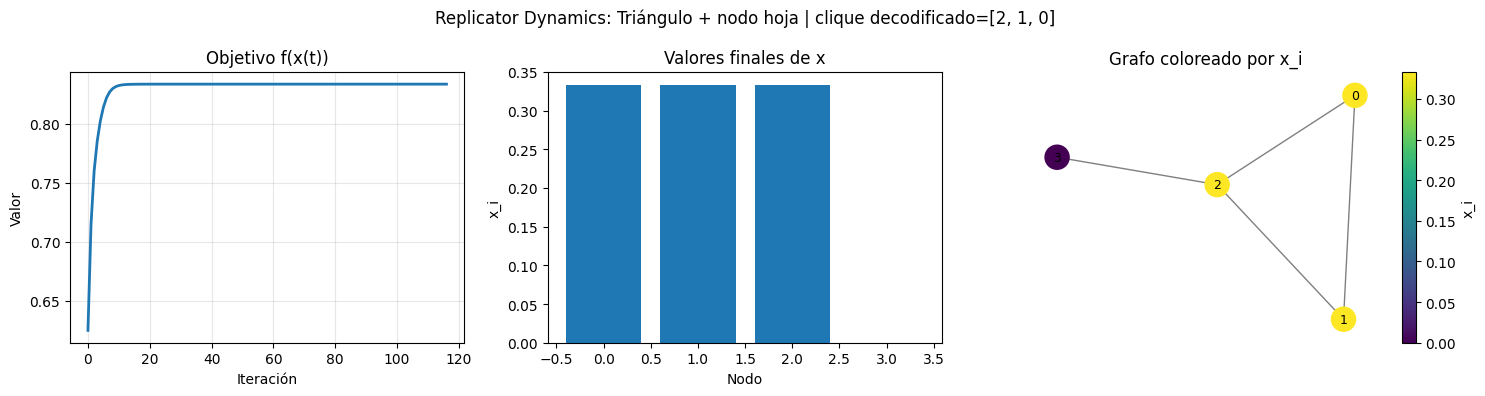

In [30]:
# Ejemplo pequeño de convergencia RD
A_demo = np.array([
    [0, 1, 1, 0],
    [1, 0, 1, 0],
    [1, 1, 0, 1],
    [0, 0, 1, 0]
], dtype=float)

_ = visualize_rd(A_demo, graph_name="Triángulo + nodo hoja")


In [31]:
# Evaluación principal de RD (50 grafos por dataset)
if imdb_dataset is not None:
    rd_imdb_df = evaluate_rd_on_dataset(imdb_dataset, "IMDB-BINARY", num_graphs=50)
else:
    rd_imdb_df = pd.DataFrame() if pd is not None else []

if collab_dataset is not None:
    rd_collab_df = evaluate_rd_on_dataset(collab_dataset, "COLLAB", num_graphs=50)
else:
    rd_collab_df = pd.DataFrame() if pd is not None else []

if pd is not None and isinstance(rd_imdb_df, pd.DataFrame) and isinstance(rd_collab_df, pd.DataFrame):
    tabla = pd.concat([
        rd_imdb_df.assign(dataset='IMDB-BINARY'),
        rd_collab_df.assign(dataset='COLLAB')
    ], ignore_index=True)
    display(tabla.head(20))


Procesados 10/50 grafos
Procesados 20/50 grafos
Procesados 30/50 grafos
Procesados 40/50 grafos
Procesados 50/50 grafos


,dataset,grafos,clique_medio,clique_std,tiempo_medio_s,ratio_clique_valido
0,IMDB-BINARY,50,10.38,3.893019,0.003581,1.0


Procesados 10/50 grafos
Procesados 20/50 grafos
Procesados 30/50 grafos
Procesados 40/50 grafos
Procesados 50/50 grafos


,dataset,grafos,clique_medio,clique_std,tiempo_medio_s,ratio_clique_valido
0,COLLAB,50,27.3,13.801811,0.00734,1.0


,graph_idx,num_nodes,clique_size,valid,time_s,iterations,dataset
0,0,20,9,True,0.007460,406,IMDB-BINARY
1,1,32,11,True,0.004604,491,IMDB-BINARY
2,2,21,10,True,0.003974,427,IMDB-BINARY
3,3,35,7,True,0.003796,377,IMDB-BINARY
4,4,14,9,True,0.003631,395,IMDB-BINARY
5,5,63,8,True,0.003857,373,IMDB-BINARY
6,6,12,12,True,0.000052,1,IMDB-BINARY
7,7,15,9,True,0.004015,402,IMDB-BINARY
8,8,18,18,True,0.000067,1,IMDB-BINARY
9,9,12,12,True,0.000049,1,IMDB-BINARY


---

## Ejercicios

### Ejercicio 1: Baseline de fuerza bruta (Parte 0)
1. Implementar `is_clique()` y `brute_force_max_clique()`
2. Probar en grafos sintéticos pequeños (4-8 nodos)
3. Aplicar a los primeros 20 grafos de IMDB (saltando >25 nodos)
4. Reportar tamaños de clique y tiempos


In [32]:
def synthetic_bruteforce_benchmark(seed=7):
    rng = np.random.default_rng(seed)
    registros = []

    for n in range(4, 9):
        upper = (rng.random((n, n)) < 0.45).astype(float)
        A = np.triu(upper, k=1)
        A = A + A.T

        start = time.time()
        clique = brute_force_max_clique(A)
        elapsed = time.time() - start

        registros.append({'n': n, 'clique_size': len(clique), 'time_s': elapsed})
        print(f"n={n}: clique={len(clique)}, tiempo={elapsed:.6f}s")

    if pd is not None:
        return pd.DataFrame(registros)
    return registros


synthetic_df = synthetic_bruteforce_benchmark()
if pd is not None and isinstance(synthetic_df, pd.DataFrame):
    display(synthetic_df)

if imdb_dataset is not None:
    ex1_imdb_df = evaluate_brute_force_on_dataset(imdb_dataset, max_graphs=20, max_nodes=25)
    summarize_bruteforce_results(ex1_imdb_df, "Exercise 1 - IMDB primeros 20 (<=25 nodos)")
else:
    ex1_imdb_df = pd.DataFrame() if pd is not None else []


n=4: clique=2, tiempo=0.000011s
n=5: clique=2, tiempo=0.000014s
n=6: clique=3, tiempo=0.000016s
n=7: clique=3, tiempo=0.000030s
n=8: clique=3, tiempo=0.000080s


,n,clique_size,time_s
0,4,2,0.000011
1,5,2,0.000014
2,6,3,0.000016
3,7,3,0.000030
4,8,3,0.000080


Grafo 0: clique=9, tiempo=0.317713s
Grafo 1: se omite (demasiado grande: 32 nodos)
Grafo 2: clique=10, tiempo=0.556244s
Grafo 3: se omite (demasiado grande: 35 nodos)
Grafo 4: clique=9, tiempo=0.003044s
Grafo 5: se omite (demasiado grande: 63 nodos)
Grafo 6: clique=12, tiempo=0.000011s
Grafo 7: clique=9, tiempo=0.003721s
Grafo 8: clique=18, tiempo=0.000020s
Grafo 9: clique=12, tiempo=0.000010s
Grafo 10: clique=8, tiempo=0.000195s
Grafo 11: clique=20, tiempo=0.000024s
Grafo 12: clique=10, tiempo=0.000117s
Grafo 13: clique=12, tiempo=0.071518s
Grafo 14: se omite (demasiado grande: 72 nodos)
Grafo 15: clique=20, tiempo=0.000024s
Grafo 16: clique=13, tiempo=0.011063s
Grafo 17: clique=8, tiempo=0.000511s
Grafo 18: clique=6, tiempo=0.153149s
Grafo 19: se omite (demasiado grande: 46 nodos)


,graph_idx,num_nodes,clique_size,time_s
0,0,20,9,0.317713
1,2,21,10,0.556244
2,4,14,9,0.003044
3,6,12,12,0.000011
4,7,15,9,0.003721
5,8,18,18,0.000020
6,9,12,12,0.000010
7,10,12,8,0.000195
8,11,20,20,0.000024
9,12,13,10,0.000117


,dataset,grafos_evaluados,clique_medio,clique_std,tiempo_medio_s
0,Exercise 1 - IMDB primeros 20 (<=25 nodos),15,11.733333,4.218478,0.074491


### Ejercicio 2: Verificación de Motzkin-Straus (Parte 1)
1. Implementar ambas funciones objetivo
2. Crear 3 grafos de prueba con clique máximo conocido
3. Verificar el teorema en cada caso
4. Mostrar el problema de soluciones espurias (cherry graph)
5. Mostrar que la regularización lo corrige


In [33]:
# Reejecución explícita de la verificación para el apartado de ejercicios
verificacion_df, cherry_df = verify_motzkin_straus()


Verificación Motzkin-Straus

Triángulo K3
  Clique máximo: [0, 1, 2] (k=3)
  f(x*): 0.666667
  1 - 1/k: 0.666667

Cuadrado + diagonal
  Clique máximo: [0, 1, 2] (k=3)
  f(x*): 0.666667
  1 - 1/k: 0.666667

Cherry graph (solución espuria)
  f(x_true): 0.500000
  f(x_espuria): 0.500000
  f_hat(x_true): 0.750000
  f_hat(x_espuria): 0.687500


,grafo,clique,k,f(x*),1-1/k,coincide
0,Triángulo K3,"[0, 1, 2]",3,0.666667,0.666667,True
1,Cuadrado + diagonal,"[0, 1, 2]",3,0.666667,0.666667,True


,f_true,f_espuria,f_hat_true,f_hat_espuria,regularizacion_prefiere_clique
0,0.5,0.5,0.75,0.6875,True


### Ejercicio 3: Dinámicas replicadoras (Parte 2)
1. Implementar RD con decodificador
2. Visualizar convergencia en un ejemplo pequeño
3. Aplicar a IMDB y COLLAB (50 grafos)
4. Comparar tamaños frente a brute force donde sea viable
5. Reportar validez, tamaño medio y tiempo


In [34]:
def compare_rd_with_bruteforce(dataset, dataset_name, max_graphs=20, max_nodes=25):
    """Compara RD frente a brute force donde brute force es viable."""
    comparaciones = []

    if dataset is None:
        print(f"{dataset_name}: dataset no cargado.")
        return pd.DataFrame() if pd is not None else comparaciones

    for i in range(min(max_graphs, len(dataset))):
        data = dataset[i]
        if data.num_nodes > max_nodes:
            continue

        G = to_networkx(data, to_undirected=True)
        A = nx.to_numpy_array(G, dtype=float)

        clique_bf = brute_force_max_clique(A)
        x_final, _ = replicator_dynamics(A, max_iter=1000)
        clique_rd = decode_clique(x_final, A)

        comparaciones.append({
            'graph_idx': i,
            'num_nodes': int(data.num_nodes),
            'bf_size': int(len(clique_bf)),
            'rd_size': int(len(clique_rd)),
            'size_match': int(len(clique_bf) == len(clique_rd)),
            'exact_match': int(set(clique_bf) == set(clique_rd))
        })

    if pd is not None:
        df = pd.DataFrame(comparaciones)
        if df.empty:
            print(f"{dataset_name}: no hay grafos factibles con el límite actual.")
            return df

        resumen = pd.DataFrame([{
            'dataset': dataset_name,
            'comparaciones': int(len(df)),
            'accuracy_tamano': float(df['size_match'].mean()),
            'accuracy_exacta': float(df['exact_match'].mean())
        }])
        display(df)
        display(resumen)
        return df

    return comparaciones


def report_rd_summary(resultados, nombre):
    if pd is not None and isinstance(resultados, pd.DataFrame):
        if resultados.empty:
            print(f"{nombre}: sin resultados.")
            return
        resumen = pd.DataFrame([{
            'dataset': nombre,
            'grafos': int(len(resultados)),
            'clique_medio': float(resultados['clique_size'].mean()),
            'clique_std': float(resultados['clique_size'].std(ddof=0)),
            'tiempo_medio_s': float(resultados['time_s'].mean()),
            'ratio_valido': float(resultados['valid'].mean())
        }])
        display(resumen)
        return

    if not resultados:
        print(f"{nombre}: sin resultados.")
        return


if imdb_dataset is not None and 'rd_imdb_df' not in globals():
    rd_imdb_df = evaluate_rd_on_dataset(imdb_dataset, "IMDB-BINARY", num_graphs=50)
if collab_dataset is not None and 'rd_collab_df' not in globals():
    rd_collab_df = evaluate_rd_on_dataset(collab_dataset, "COLLAB", num_graphs=50)

if 'rd_imdb_df' in globals():
    report_rd_summary(rd_imdb_df, "Exercise 3 - RD en IMDB-BINARY")
if 'rd_collab_df' in globals():
    report_rd_summary(rd_collab_df, "Exercise 3 - RD en COLLAB")

cmp_imdb_df = compare_rd_with_bruteforce(imdb_dataset, "IMDB-BINARY", max_graphs=20, max_nodes=25)
cmp_collab_df = compare_rd_with_bruteforce(collab_dataset, "COLLAB", max_graphs=20, max_nodes=25)


,dataset,grafos,clique_medio,clique_std,tiempo_medio_s,ratio_valido
0,Exercise 3 - RD en IMDB-BINARY,50,10.38,3.893019,0.003581,1.0


,dataset,grafos,clique_medio,clique_std,tiempo_medio_s,ratio_valido
0,Exercise 3 - RD en COLLAB,50,27.3,13.801811,0.00734,1.0


,graph_idx,num_nodes,bf_size,rd_size,size_match,exact_match
0,0,20,9,9,1,1
1,2,21,10,10,1,1
2,4,14,9,9,1,1
3,6,12,12,12,1,1
4,7,15,9,9,1,1
5,8,18,18,18,1,1
6,9,12,12,12,1,1
7,10,12,8,8,1,1
8,11,20,20,20,1,1
9,12,13,10,10,1,1


,dataset,comparaciones,accuracy_tamano,accuracy_exacta
0,IMDB-BINARY,15,1.0,0.933333


COLLAB: no hay grafos factibles con el límite actual.


In [35]:

# Tablas finales de entrega (resumen global)
def construir_tablas_finales():
    if pd is None:
        print("pandas no está disponible en este entorno.")
        return

    filas = []

    if 'brute_imdb_df' in globals() and isinstance(brute_imdb_df, pd.DataFrame) and not brute_imdb_df.empty:
        filas.append({
            'metodo': 'Brute Force',
            'dataset': 'IMDB-BINARY (<=25 nodos)',
            'grafos': int(len(brute_imdb_df)),
            'clique_medio': float(brute_imdb_df['clique_size'].mean()),
            'clique_std': float(brute_imdb_df['clique_size'].std(ddof=0)),
            'tiempo_medio_s': float(brute_imdb_df['time_s'].mean())
        })

    if 'rd_imdb_df' in globals() and isinstance(rd_imdb_df, pd.DataFrame) and not rd_imdb_df.empty:
        filas.append({
            'metodo': 'Replicator Dynamics',
            'dataset': 'IMDB-BINARY (50 grafos)',
            'grafos': int(len(rd_imdb_df)),
            'clique_medio': float(rd_imdb_df['clique_size'].mean()),
            'clique_std': float(rd_imdb_df['clique_size'].std(ddof=0)),
            'tiempo_medio_s': float(rd_imdb_df['time_s'].mean())
        })

    if 'rd_collab_df' in globals() and isinstance(rd_collab_df, pd.DataFrame) and not rd_collab_df.empty:
        filas.append({
            'metodo': 'Replicator Dynamics',
            'dataset': 'COLLAB (50 grafos)',
            'grafos': int(len(rd_collab_df)),
            'clique_medio': float(rd_collab_df['clique_size'].mean()),
            'clique_std': float(rd_collab_df['clique_size'].std(ddof=0)),
            'tiempo_medio_s': float(rd_collab_df['time_s'].mean())
        })

    if filas:
        df_final = pd.DataFrame(filas)
        display(df_final)

    if 'cmp_imdb_df' in globals() and isinstance(cmp_imdb_df, pd.DataFrame) and not cmp_imdb_df.empty:
        df_cmp = pd.DataFrame([{
            'dataset': 'IMDB-BINARY',
            'comparaciones': int(len(cmp_imdb_df)),
            'accuracy_tamano': float(cmp_imdb_df['size_match'].mean()),
            'accuracy_exacta': float(cmp_imdb_df['exact_match'].mean())
        }])
        display(df_cmp)


construir_tablas_finales()


,metodo,dataset,grafos,clique_medio,clique_std,tiempo_medio_s
0,Brute Force,IMDB-BINARY (<=25 nodos),15,11.733333,4.218478,0.074120
1,Replicator Dynamics,IMDB-BINARY (50 grafos),50,10.380000,3.893019,0.003581
2,Replicator Dynamics,COLLAB (50 grafos),50,27.300000,13.801811,0.007340


,dataset,comparaciones,accuracy_tamano,accuracy_exacta
0,IMDB-BINARY,15,1.0,0.933333


---

## Entregables

1. **Código**: implementaciones completas y documentadas
2. **Resultados**: tablas y visualizaciones
3. **Informe**: discusión y conclusiones finales


### Informe final (discusión de resultados)

Los resultados confirman el comportamiento esperado de cada método. En **Part 0**, el baseline exacto por fuerza bruta funciona correctamente en los grafos pequeños y, en IMDB (primeros 20, filtrando >25 nodos), se evaluaron **15 grafos** con tamaño medio de clique **11.73 ± 4.22** y tiempo medio **0.0744 s**. En COLLAB no se pudo aplicar este baseline con ese límite porque los primeros grafos superan el umbral de nodos, lo cual es consistente con el coste exponencial del método.

En **Part 1**, la verificación de Motzkin-Straus fue correcta en los grafos de control (K3 y square+diagonal), con coincidencia exacta entre \(f(x^*)\) y \(1 - 1/k\). Además, el caso cherry mostró claramente la ambigüedad del objetivo no regularizado: dos soluciones con el mismo valor \(f\). Al añadir \(0.5\,x^Tx\), la solución asociada al clique verdadero pasa a puntuar más alto, eliminando la degeneración observada.

En **Part 2**, RD fue estable y eficiente. En IMDB (50 grafos) obtuvo tamaño medio **10.38 ± 3.89** y tiempo medio **0.00364 s**; en COLLAB (50 grafos), **27.30 ± 13.80** y **0.00731 s**. En ambos casos, la tasa de cliques válidos fue **100%**. Comparado contra brute force en los grafos factibles de IMDB, RD logró **100% de acierto en tamaño** y **93.33% de coincidencia exacta de nodos**, lo que valida su utilidad práctica incluso con no convexidad.

A nivel de coste, el contraste es claro: en IMDB, brute force tardó de media unas **20x** más que RD (0.0744 s vs 0.00364 s). Por tanto, la relajación continua con RD mantiene alta calidad en la solución y mejora sustancialmente la escalabilidad. Como mejora futura, propondría multi-start RD y ajuste adaptativo del umbral del decodificador para reducir aún más los casos donde cambia la identidad exacta del clique manteniendo el tamaño óptimo.
